In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def loadData():
    with np.load("notMNIST.npz") as data:
        Data, Target = data["images"], data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx] / 255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:15000], Target[:15000]
        validData, validTarget = Data[15000:16000], Target[15000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

def convertOneHot(trainTarget, validTarget, testTarget):
    newtrain = np.zeros((trainTarget.shape[0], 10))
    newvalid = np.zeros((validTarget.shape[0], 10))
    newtest = np.zeros((testTarget.shape[0], 10))

    for item in range(0, trainTarget.shape[0]):
        newtrain[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newvalid[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newtest[item][testTarget[item]] = 1
    return newtrain, newvalid, newtest

def shuffle(trainData, trainTarget):
    np.random.seed(421)
    randIndx = np.arange(len(trainData))
    target = trainTarget
    np.random.shuffle(randIndx)
    data, target = trainData[randIndx], target[randIndx]
    return data, target
    
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
#print(trainData.shape)
train_y, valid_y, test_y = convertOneHot(trainTarget, validTarget, testTarget)
#train_x = trainData
#validation_X = validData
#test_X = testData
train_x = trainData.reshape(-1, 28, 28, 1)
validation_x = validData.reshape(-1, 28, 28, 1)
test_x = testData.reshape(-1, 28, 28, 1)

In [3]:
training_epoch = 50
learning_rate = 0.0001 
mini_batch_size = 32
#reshuffle = 15000 / mini_batch_size
#total_iterations =int(training_epoch * 15000 / mini_batch_size)
x = tf.placeholder("float", [None, 28,28,1])
y = tf.placeholder("float", [None, 10])
W1 = tf.get_variable("W1", shape=[3,3,1,32],initializer=tf.contrib.layers.xavier_initializer(),dtype=tf.float32)
b1 = tf.get_variable("b1", shape=[32],initializer=tf.contrib.layers.xavier_initializer(),dtype=tf.float32)
W2 = tf.get_variable("W2", shape=[784*8,784],initializer=tf.contrib.layers.xavier_initializer(),dtype=tf.float32)
b2 = tf.get_variable("b2", shape=[784],initializer=tf.contrib.layers.xavier_initializer(),dtype=tf.float32)
W3 = tf.get_variable("W3", shape=[784,10],initializer=tf.contrib.layers.xavier_initializer(),dtype=tf.float32)
b3 = tf.get_variable("b3", shape=[10],initializer=tf.contrib.layers.xavier_initializer(),dtype=tf.float32)

In [4]:
# convolutional layer
# 1*1 strides
conv = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='SAME')
conv = tf.nn.bias_add(conv, b1)
conv = tf.nn.relu(conv)
batch_mean, batch_var = tf.nn.moments(conv,[0, 1, 2])
# batch normalization layer
Batch_normalization = tf.nn.batch_normalization(conv,batch_mean,batch_var,None,None,1e-5)
# 2x2 max pooling layer, 2x2 strides
max_pool = tf.nn.max_pool(Batch_normalization, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
# Fully connected layer 1
fc1 = tf.reshape(max_pool, [-1, W2.get_shape()[0]])
fc1 = tf.add(tf.matmul(fc1, W2), b2)
#dropout layers
#training = tf.placeholder_with_default(False, shape=(), name='training')
#dropout = tf.layers.dropout(fc1, 0.1, training=training)
#fc1 = tf.reshape(dropout, [-1, W3.get_shape()[0]])
fc1 = tf.nn.relu(fc1)
# Fully connected layer 2
fc2 = tf.reshape(fc1, [-1, W3.get_shape()[0]])
fc2 = tf.add(tf.matmul(fc2, W3), b3)
pred = tf.nn.softmax(fc2)
# Softmax cross entropy
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
#L2 regularization
#meanSquaredError = tf.losses.mean_squared_error(predictions=pred, labels=y)
#weight_loss = tf.nn.l2_loss(W3) * 0.01
#cost = meanSquaredError + weight_loss
#regularizer = tf.contrib.layers.l2_regularizer(scale=0.001)
#hidden1 = tf.layers.dense(fc2, 784, kernel_regularizer=regularizer)
#hidden1_act = tf.nn.relu(hidden1)
#
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [5]:
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    test_loss = []
    validation_loss = []
    train_accuracy = []
    validation_accuracy = []
    test_accuracy= []
    total_epoch=[]
    
    for epoch in range(training_epoch):
        total_epoch.append(epoch)
        for iter in range (int(15000 / mini_batch_size)):
            x_batch = train_x[(iter*mini_batch_size):(iter*mini_batch_size) + mini_batch_size]
            y_batch = train_y[(iter*mini_batch_size):(iter*mini_batch_size) + mini_batch_size]
            opt = sess.run(optimizer, feed_dict={x: x_batch,y: y_batch})
            trainloss, trainaccuracy = sess.run([cost, accuracy], feed_dict={x: x_batch,y: y_batch})
        validloss,validaccuracy = sess.run([cost, accuracy], feed_dict={x: validation_x,y : valid_y})
        testloss, testaccuracy = sess.run([cost, accuracy], feed_dict={x: test_x,y: test_y})
        train_loss.append(trainloss)
        train_accuracy.append(trainaccuracy)
        validation_loss.append(validloss)
        validation_accuracy.append(validaccuracy)
        test_loss.append(testloss)
        test_accuracy.append(testaccuracy)
        print("Epoch " + str(epoch+1) + ": Train Loss:" + "{:.3f}".format(trainloss) + ", Train Acc:" + "{:.2f}".format(trainaccuracy * 100) + "%, Valid Loss:" + "{:.3f}".format(validloss) + ", Valid Acc:" + "{:.2f}".format(validaccuracy * 100) + "%, Test Loss:" + "{:.3f}".format(testloss) + ", Test Acc:" + "{:.2f}".format(testaccuracy * 100) + "%")
        #if iter % int(reshuffle) == 0 :
        train_x ,  train_y = shuffle(train_x, train_y)


Epoch 1: Train Loss:1.579, Train Acc:87.50%, Valid Loss:1.539, Valid Acc:92.40%, Test Loss:1.552, Test Acc:91.19%
Epoch 2: Train Loss:1.585, Train Acc:87.50%, Valid Loss:1.539, Valid Acc:92.20%, Test Loss:1.545, Test Acc:91.78%
Epoch 3: Train Loss:1.527, Train Acc:93.75%, Valid Loss:1.535, Valid Acc:92.60%, Test Loss:1.543, Test Acc:91.96%
Epoch 4: Train Loss:1.550, Train Acc:90.62%, Valid Loss:1.530, Valid Acc:93.50%, Test Loss:1.541, Test Acc:92.07%
Epoch 5: Train Loss:1.494, Train Acc:96.88%, Valid Loss:1.532, Valid Acc:93.10%, Test Loss:1.540, Test Acc:92.11%
Epoch 6: Train Loss:1.487, Train Acc:96.88%, Valid Loss:1.527, Valid Acc:93.50%, Test Loss:1.536, Test Acc:92.66%
Epoch 7: Train Loss:1.492, Train Acc:96.88%, Valid Loss:1.529, Valid Acc:93.20%, Test Loss:1.539, Test Acc:92.18%
Epoch 8: Train Loss:1.553, Train Acc:90.62%, Valid Loss:1.533, Valid Acc:92.70%, Test Loss:1.536, Test Acc:92.51%
Epoch 9: Train Loss:1.572, Train Acc:87.50%, Valid Loss:1.530, Valid Acc:93.20%, Test Lo

C:\Users\user\Anaconda3\envs\tensorflow_env\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


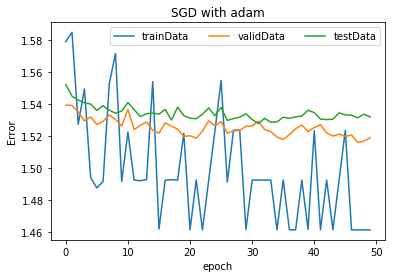

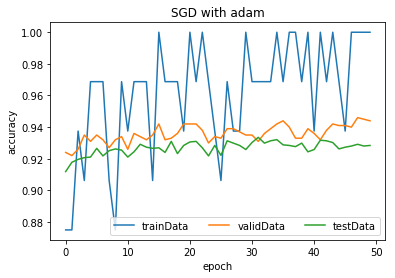

In [6]:
def figPlot(figureNumber,datas, title,yLabel): 
    f = plt.figure(figureNumber)
    plt.xlabel('epoch')
    title = title 
    plt.title(title)  
    plt.ylabel(yLabel)
    labels =[]
    for Value, Data in datas.items(): 
        plt.plot(Data) 
        labels.append(Value) 
    plt.legend(labels, ncol = len(labels))
    f.show()

figPlot(1,{"trainData" : train_loss, "validData" : validation_loss, "testData" : test_loss},"SGD with adam","Error") 
figPlot(2,{"trainData" : train_accuracy, "validData" : validation_accuracy, "testData" : test_accuracy},"SGD with adam","accuracy") 